In [16]:
from __future__ import print_function 

%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
%matplotlib inline

import os, sys
import numpy as np
import time

import tensorflow as tf
from tensorflow.keras import backend as K

import pandas as pd
import pickle
import gc, re, copy
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils
from IPython.display import display

# Project imports 
from data import mnist_m as mnistm
from data import mnist
from data.label_shift import label_shift_linear, plot_labeldist, plot_splitbars
from data.tasks import load_task
from experiments.training import *
from experiments.SL_bound import *
from experiments.DA_bound import *
from bounds.bounds import *
from util.kl import *
from util.misc import *
from results.plotting import *

# Hyper-parameters
task = 2
binary=True
if binary:
    results_folder = "/cephyr/users/adambre/Alvis/mnist_transfer/results/task"+str(task)+"/Binary"
else:
    results_folder = "/cephyr/users/adambre/Alvis/mnist_transfer/results/task"+str(task)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
r_files = [f for f in os.listdir(results_folder) if ('results.pkl' in f and not 'prior_results.pkl' in f)]

D = pd.DataFrame({})

for r in r_files: 
    Dr = pd.read_pickle(os.path.join(results_folder, r))
    D = pd.concat([D, Dr], axis=0,sort=False)
    
D['germain_bound'] = np.nan
D['beta_bound'] = np.nan

D = D.sort_values(by=[ 'alpha','Weightupdates', 'sigma'])#

D.head(20)

,Weightupdates,train_germain,target_germain,KL,e_s,e_t,d_tx,d_sx,error_std,target_error_std,...,sigma,epsilon,checkpoint,delta,m_bound,m_target,n_classifiers,seed,germain_bound,beta_bound
0,275.0,0.084991,0.172868,109142.880657,0.079189,0.163445,0.018846,0.011605,0.000638,0.003093,...,0.003,0.010,1_275,0.05,70010,69990,10,69105,NaN,NaN
0,275.0,0.092820,0.227566,108909.517662,0.088592,0.219231,0.016670,0.008456,0.000990,0.003539,...,0.003,0.030,1_275,0.05,70010,69990,10,69105,NaN,NaN
0,275.0,0.091174,0.206844,109357.584779,0.086315,0.198923,0.015842,0.009719,0.001143,0.003362,...,0.003,0.001,1_275,0.05,70010,69990,10,69105,NaN,NaN
0,275.0,0.164068,0.246412,11019.228753,0.091374,0.151144,0.190534,0.145388,0.044363,0.035401,...,0.030,0.010,1_275,0.05,70010,69990,10,69105,NaN,NaN
0,275.0,0.147129,0.267722,10980.990085,0.083954,0.178230,0.178984,0.126351,0.045583,0.037379,...,0.030,0.001,1_275,0.05,70010,69990,10,69105,NaN,NaN
0,275.0,0.177693,0.303342,10910.622788,0.067461,0.153889,0.298906,0.220464,0.068690,0.043562,...,0.030,0.030,1_275,0.05,70010,69990,10,69105,NaN,NaN
0,275.0,0.494826,0.495644,1093.098726,0.221273,0.221402,0.548484,0.547106,0.017386,0.014760,...,0.300,0.030,1_275,0.05,70010,69990,10,69105,NaN,NaN
0,330.0,0.079049,0.174231,109268.226609,0.073531,0.164626,0.019208,0.011036,0.001703,0.006033,...,0.003,0.010,1_330,0.05,70010,69990,10,69105,NaN,NaN
0,330.0,0.080910,0.164311,109276.268651,0.075702,0.155679,0.017264,0.010416,0.001641,0.003750,...,0.003,0.001,1_330,0.05,70010,69990,10,69105,NaN,NaN
0,330.0,0.081220,0.165878,109464.347910,0.075002,0.155769,0.020217,0.012435,0.001111,0.004290,...,0.003,0.030,1_330,0.05,70010,69990,10,69105,NaN,NaN


In [32]:
m_bound = D['m_bound'].values[0]
delta = D['delta'].values[0]

###### average over all seeds
new_df=pd.DataFrame({})

for a in [0,0.3]:#np.sort(D['alpha'].unique()):
    for s in np.sort(D['sigma'].unique()):
        for e in np.sort(D['epsilon'].unique()): 
            for w in np.sort(D['Weightupdates'].unique()):
                stratum = (D['sigma']==s)&(D['alpha']==a)&(D['epsilon']==e)&(D['Weightupdates']==w)
                if(len(D[stratum])>=2):
                    print(D[stratum])
sys.exit(-1)


### take 

 # calculate disrho bound

for a in [0,0.3]:#np.sort(D['alpha'].unique()):
    for s in np.sort(D['sigma'].unique()):
        for e in np.sort(D['epsilon'].unique()):         
            stratum = (D['sigma']==s)&(D['alpha']==a)&(D['epsilon']==e)#

            if(len(D[stratum])==0):
                print(a)
                print(s)
                print(e)
            else:
                train_germain = D[stratum]['train_germain'].values
                e_s = D[stratum]['e_s'].values
                e_t = D[stratum]['e_t'].values
                d_tx = D[stratum]['d_tx'].values
                d_sx = D[stratum]['d_sx'].values
                KL = D[stratum]['KL'].values

                res, bestparam, boundparts = grid_search(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,m_bound,len(KL))
                res_inf, _, _ = grid_search(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,1e16,len(KL))

                # calculate beta bound
                [res2, bestparam2, boundparts2] = grid_search(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,m_bound,len(KL),beta_bound=True)
                [res2_inf, _, _] = grid_search(train_germain,e_s,e_t,d_tx,d_sx,KL,delta,1e16,len(KL),beta_bound=True)

                D.loc[stratum,'germain_bound'] = res
                D.loc[stratum,'beta_bound'] = res2
                D.loc[stratum,'germain_bound_inf'] = res_inf
                D.loc[stratum,'beta_bound_inf'] = res2_inf



SystemExit: -1

,Weightupdates,train_germain,target_germain,KL,e_s,e_t,d_tx,d_sx,error_std,target_error_std,...,checkpoint,delta,m_bound,m_target,n_classifiers,seed,germain_bound,beta_bound,germain_bound_inf,beta_bound_inf
0,275.0,0.084991,0.172868,109142.880657,0.079189,0.163445,0.018846,0.011605,0.000638,0.003093,...,1_275,0.05,70010.0,69990.0,10.0,69105.0,6.289899,42.051524,0.134652,0.879619
0,275.0,0.092820,0.227566,108909.517662,0.088592,0.219231,0.016670,0.008456,0.000990,0.003539,...,1_275,0.05,70010.0,69990.0,10.0,69105.0,6.345452,42.165708,0.166659,0.981858
0,275.0,0.091174,0.206844,109357.584779,0.086315,0.198923,0.015842,0.009719,0.001143,0.003362,...,1_275,0.05,70010.0,69990.0,10.0,69105.0,6.359070,42.511911,0.153903,0.956520
0,275.0,0.164068,0.246412,11019.228753,0.091374,0.151144,0.190534,0.145388,0.044363,0.035401,...,1_275,0.05,70010.0,69990.0,10.0,69105.0,1.424512,7.793300,0.239406,1.099388
0,275.0,0.147129,0.267722,10980.990085,0.083954,0.178230,0.178984,0.126351,0.045583,0.037379,...,1_275,0.05,70010.0,69990.0,10.0,69105.0,1.436900,8.269601,0.247211,1.012070
0,275.0,0.177693,0.303342,10910.622788,0.067461,0.153889,0.298906,0.220464,0.068690,0.043562,...,1_275,0.05,70010.0,69990.0,10.0,69105.0,1.488565,6.692222,0.299665,0.890810
0,275.0,0.494826,0.495644,1093.098726,0.221273,0.221402,0.548484,0.547106,0.017386,0.014760,...,1_275,0.05,70010.0,69990.0,10.0,69105.0,0.831379,4.392728,0.496642,2.705845
0,330.0,0.079049,0.174231,109268.226609,0.073531,0.164626,0.019208,0.011036,0.001703,0.006033,...,1_330,0.05,70010.0,69990.0,10.0,69105.0,6.280929,41.783005,0.133062,0.817628
0,330.0,0.080910,0.164311,109276.268651,0.075702,0.155679,0.017264,0.010416,0.001641,0.003750,...,1_330,0.05,70010.0,69990.0,10.0,69105.0,6.273809,41.901952,0.128037,0.840597
0,330.0,0.081220,0.165878,109464.347910,0.075002,0.155769,0.020217,0.012435,0.001111,0.004290,...,1_330,0.05,70010.0,69990.0,10.0,69105.0,6.267458,41.689838,0.129676,0.834300


Sigma = 0.00300 Alpha = 0.00000 Epsilon = 0.03000


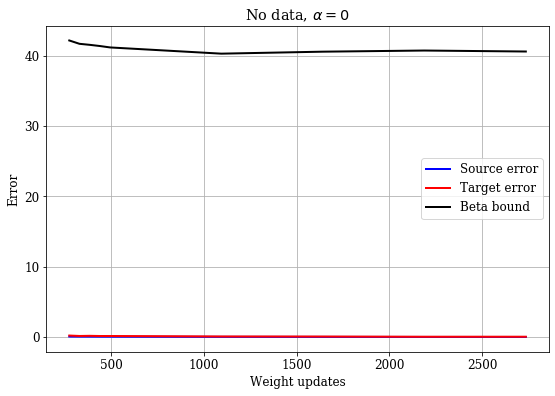

Sigma = 0.03000 Alpha = 0.00000 Epsilon = 0.03000


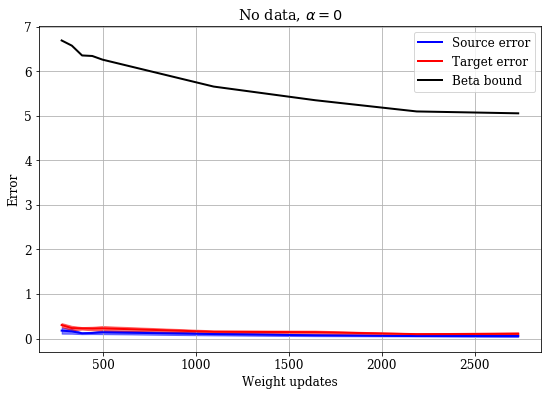

Sigma = 0.30000 Alpha = 0.00000 Epsilon = 0.03000


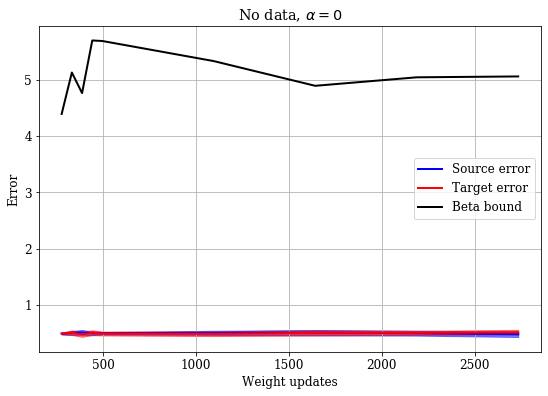

Sigma = 0.00300 Alpha = 0.80000 Epsilon = 0.03000


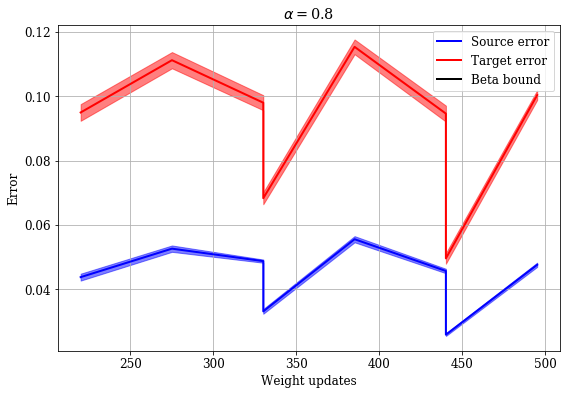

Sigma = 0.03000 Alpha = 0.80000 Epsilon = 0.03000


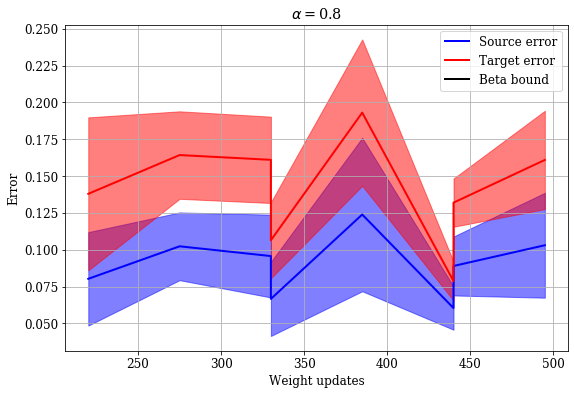

Sigma = 0.30000 Alpha = 0.80000 Epsilon = 0.03000


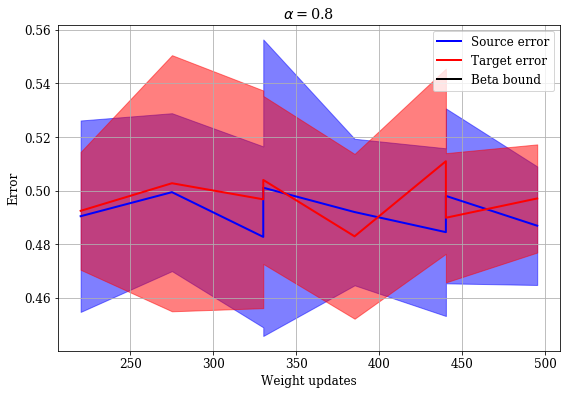

In [30]:
plt.rc('font', size=16, family='serif')
display(D.head(10))

#plt.plot(D[D['sigma']==.03]['Weightupdates'], D[D['sigma']==.03]['train_germain'])
for a in [0,0.8]:#np.sort(D['alpha'].unique()):
    for s in np.sort(D['sigma'].unique()):
        for e in [0.03]:#np.sort(D['epsilon'].unique()):
            print('Sigma = %.5f' % s, 'Alpha = %.5f' % a,'Epsilon = %.5f' % e)

            stratum = (D['sigma']==s)&(D['alpha']==a)&(D['epsilon']==e)
            #print(D[stratum].head)
            ws = D[stratum]['Weightupdates']
            e_so = D[stratum]['train_germain']
            e_ta = D[stratum]['target_germain']
            e_so_std = D[stratum]['error_std']
            e_ta_std = D[stratum]['target_error_std']
            KL = D[stratum]['KL']
            gb = D[stratum]['germain_bound']
            bb = D[stratum]['beta_bound']       
            
#             plt.figure(figsize=(9,6))
#             plt.grid(zorder=-100)

#             plt.plot(ws, e_so, label='Source error', lw=2, c='b')
#             plt.fill_between(ws, e_so-e_so_std, e_so+e_so_std, alpha=0.5, zorder=0, color='b')

#             plt.plot(ws, e_ta, label='Target error', lw=2, c='r')
#             plt.fill_between(ws, e_ta-e_ta_std, e_ta+e_ta_std, alpha=0.5, zorder=0, color='r')

#             #plt.plot(ws, gb, label='Germain bound', lw=2, c='g')
#             plt.plot(ws, bb, label='Beta bound', lw=2, c='k')

#             plt.xlim(0, 1000)
#             plt.ylim(0, 1.)
#             plt.legend()


            plt.rc('font', size=12, family='serif')
            plt.figure(figsize=(9,6))
            plt.grid(zorder=-100)

            plt.plot(ws, e_so, label='Source error', lw=2, c='b')
            plt.fill_between(ws, e_so-e_so_std, e_so+e_so_std, alpha=0.5, zorder=0, color='b')

            plt.plot(ws, e_ta, label='Target error', lw=2, c='r')
            plt.fill_between(ws, e_ta-e_ta_std, e_ta+e_ta_std, alpha=0.5, zorder=0, color='r')

            #plt.plot(ws, gb, label='Germain bound', lw=2, c='g')
            plt.plot(ws, bb, label='Beta bound', lw=2, c='k')
            plt.xlabel("Weight updates")
            plt.ylabel("Error")
            if a==0:
                plt.title(r'No data, $\alpha=0$')
            else:
                plt.title(r'$\alpha=$'+str(a))
            plt.legend()
            plt.show()

,Weightupdates,train_germain,target_germain,KL,e_s,e_t,d_tx,d_sx,error_std,target_error_std,...,checkpoint,delta,m_bound,m_target,n_classifiers,seed,germain_bound,beta_bound,germain_bound_inf,beta_bound_inf
0,150.0,0.027584,0.038162,64.213413,0.025079,0.034593,0.007138,0.005009,0.001179,0.001473,...,1_150,0.05,34379,31801,10,69105,0.116878,0.477427,0.034729,0.279162
0,150.0,0.027829,0.035249,52.622776,0.025518,0.032329,0.005839,0.004622,0.001132,0.001118,...,1_150,0.05,34379,31801,10,69105,0.107928,0.459219,0.032711,0.283339
0,150.0,0.040938,0.130546,51.612205,0.037383,0.120157,0.020779,0.007106,0.002831,0.011330,...,1_150,0.05,34379,31801,10,69105,0.178809,0.658927,0.096279,0.421192
0,150.0,0.085254,0.145639,5.262278,0.022287,0.045914,0.199450,0.125934,0.032585,0.080664,...,1_150,0.05,34379,31801,10,69105,0.212974,0.525585,0.170860,0.344657
0,150.0,0.074269,0.164081,6.421341,0.028974,0.075482,0.177199,0.090590,0.026126,0.068261,...,1_150,0.05,34379,31801,10,69105,0.227617,0.605468,0.184412,0.407014


Sigma = 0.00300 Alpha = 0.10000


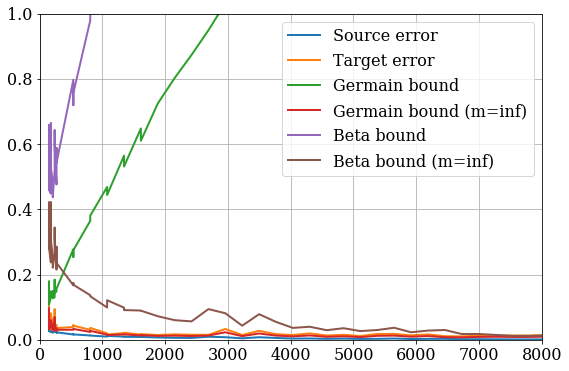

Sigma = 0.03000 Alpha = 0.10000


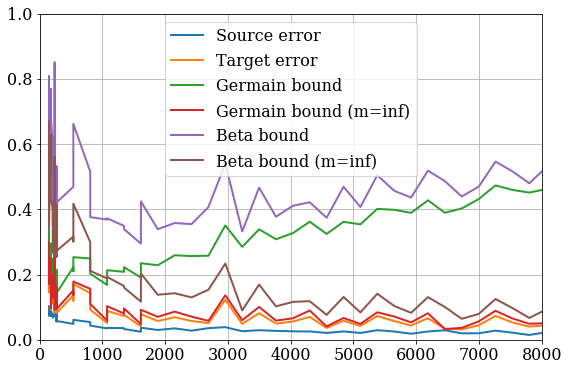

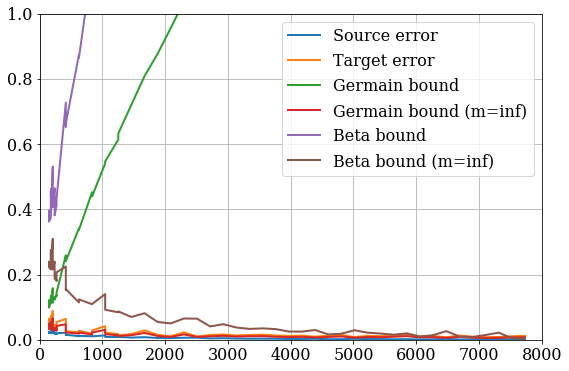

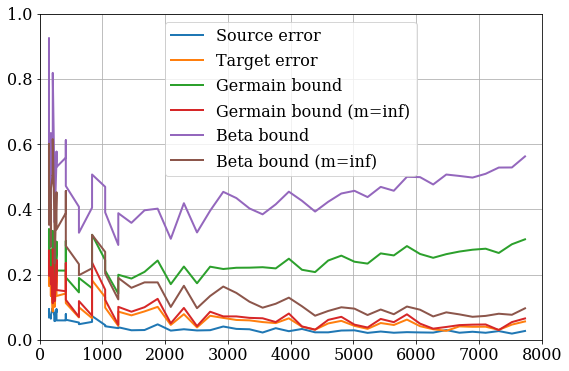

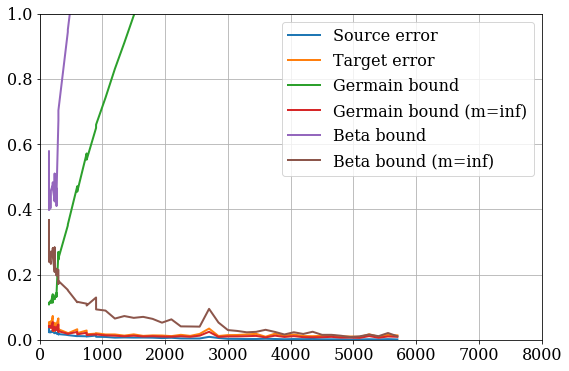

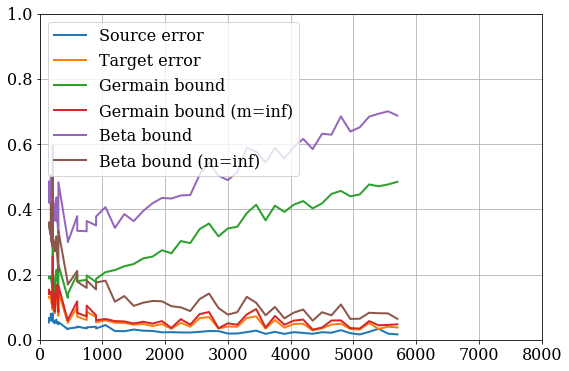

Sigma = 0.00300 Alpha = 0.30000
Sigma = 0.03000 Alpha = 0.30000
Sigma = 0.00300 Alpha = 0.50000
Sigma = 0.03000 Alpha = 0.50000


In [37]:
plt.rc('font', size=16, family='serif')
display(D.head(5))
D = D.sort_values(by='Weightupdates')

#plt.plot(D[D['sigma']==.03]['Weightupdates'], D[D['sigma']==.03]['train_germain'])
for a in np.sort(D['alpha'].unique()):
    for s in np.sort(D['sigma'].unique()):
        print('Sigma = %.5f' % s, 'Alpha = %.5f' % a)

        stratum = (D['sigma']==s)&(D['alpha']==a)
        ws = D[stratum]['Weightupdates']
        e_so = D[stratum]['train_germain']
        e_ta = D[stratum]['target_germain']
        e_so_std = D[stratum]['error_std']
        e_ta_std = D[stratum]['target_error_std']
        KL = D[stratum]['KL']
        gb = D[stratum]['germain_bound']
        gbi = D[stratum]['germain_bound_inf']
        bb = D[stratum]['beta_bound']       
        bbi = D[stratum]['beta_bound_inf']       

        plt.figure(figsize=(9,6))
        plt.grid(zorder=-100)

        plt.plot(ws, e_so, label='Source error', lw=2)    
        plt.plot(ws, e_ta, label='Target error', lw=2)    
        plt.plot(ws, gb, label='Germain bound', lw=2)
        plt.plot(ws, gbi, label='Germain bound (m=inf)', lw=2)
        plt.plot(ws, bb, label='Beta bound', lw=2)
        plt.plot(ws, bbi, label='Beta bound (m=inf)', lw=2)
        plt.xlim(0, 8000)
        plt.ylim(0, 1)

        plt.legend()
        plt.show()